In [1]:
import pandas as pd
import os
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import Dataset , DataLoader
import matplotlib.pyplot as plt
import IPython.display as ipd 
import os
import numpy as np
import librosa
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm.auto import tqdm
import seaborn as sns

In [2]:
data = pd.read_csv("/kaggle/input/speech-dataset/UrbanSound8K/metadata/UrbanSound8K.csv")

In [3]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


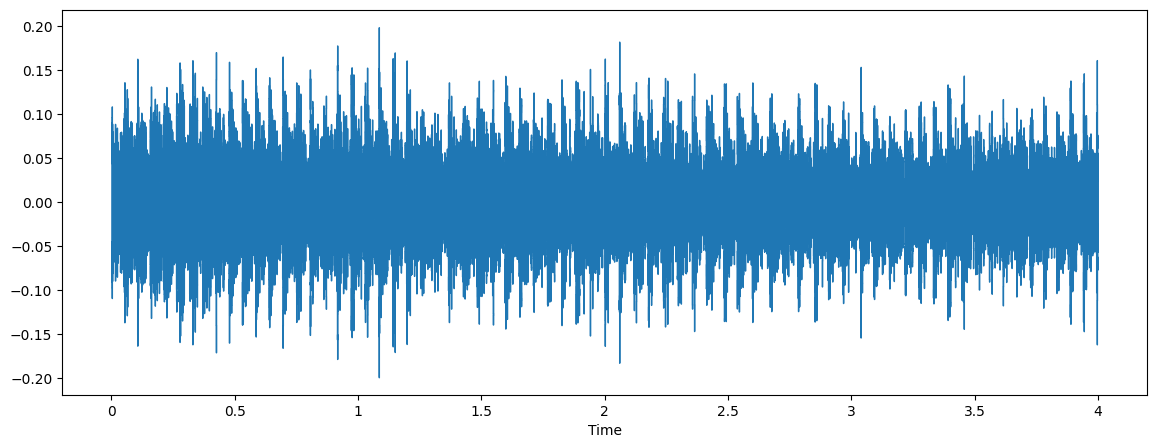

In [4]:
filename='/kaggle/input/speech-dataset/UrbanSound8K/audio/fold1/103074-7-4-3.wav'  # select a random one
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [5]:
def create_hann_window(window_length):
    n = np.arange(window_length)
    return 0.5 * (1 - np.cos(2 * np.pi * n / (window_length - 1)))

In [6]:
def create_hamming_window(window_length):
    n = np.arange(window_length)
    return 0.54 - 0.46 * np.cos(2 * np.pi * n / (window_length - 1))

In [7]:
def create_rectangular_window(window_length):
   return np.ones(window_length)

In [8]:
def custom_stft(signal, window, hop_length):
   
    n_fft = len(window)
    # Calculate number of frames
    n_frames = 1 + (len(signal) - n_fft) // hop_length
    
    # Initialize STFT matrix
    stft_matrix = np.zeros((n_fft // 2 + 1, n_frames), dtype=complex)
    
    for i in range(n_frames):
        # Extract frame
        start = i * hop_length
        frame = signal[start:start + n_fft]
        
        if len(frame) < n_fft:
            # Zero-pad if necessary
            frame = np.pad(frame, (0, n_fft - len(frame)))
        
        # Apply window
        windowed_frame = frame * window
        
        # Compute FFT
        spectrum = np.fft.rfft(windowed_frame)
        stft_matrix[:, i] = spectrum
        
    return stft_matrix

In [9]:
class UrbanSoundDataset(Dataset):
    def __init__(self, metadata_path, dataset_path, sr=22050, duration=2.5, 
                 window_length=2048, hop_length=512, window_type='hann'):
        self.metadata = pd.read_csv(metadata_path)
        self.dataset_path = dataset_path
        self.sr = sr
        self.duration = duration
        self.n_samples = int(sr * duration)
        self.window_length = window_length
        self.hop_length = hop_length
        self.window_type = window_type
        
        # Create windows
        self.windows = {
            'hann': create_hann_window(window_length),
            'hamming': create_hamming_window(window_length),
            'rectangular': create_rectangular_window(window_length)
        }
        
        # Prepare file paths and labels
        self.file_paths = [
            os.path.join(self.dataset_path, f"fold{row['fold']}", row['slice_file_name'])
            for _, row in self.metadata.iterrows()
        ]
        self.labels = self.metadata['classID'].values

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # Load audio
        signal, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
        signal = librosa.util.fix_length(signal, size=self.n_samples)
        
        # Get the appropriate window
        window = self.windows[self.window_type]
        
        # Compute STFT using custom implementation
        stft = custom_stft(signal, window, self.hop_length)
        
        # Convert to magnitude spectrogram
        spectrogram = np.abs(stft)
        
        # Convert to log scale
        spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
        
        return spectrogram, label

In [10]:
def compare_windows(signal, window_length=2048, hop_length=512):
   
    windows = {
        'Hann': create_hann_window(window_length),
        'Hamming': create_hamming_window(window_length),
        'Rectangular': create_rectangular_window(window_length)
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot windows
    for i, (name, window) in enumerate(windows.items()):
        axes[0, i].plot(window)
        axes[0, i].set_title(f'{name} Window')
        axes[0, i].set_xlabel('Sample')
        axes[0, i].set_ylabel('Amplitude')
    
    # Plot spectrograms
    for i, (name, window) in enumerate(windows.items()):
        stft = custom_stft(signal, window, hop_length)
        spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        
        img = axes[1, i].imshow(spectrogram, origin='lower', aspect='auto', cmap='viridis')
        axes[1, i].set_title(f'{name} Spectrogram')
        axes[1, i].set_xlabel('Time Frame')
        axes[1, i].set_ylabel('Frequency Bin')
    
    plt.tight_layout()
    return fig

In [11]:
# Example usage
DATASET_PATH = "/kaggle/input/speech-dataset/UrbanSound8K/audio"
METADATA_PATH = "/kaggle/input/speech-dataset/UrbanSound8K/metadata/UrbanSound8K.csv"

# Create datasets with different windows
datasets = {
    'hann': UrbanSoundDataset(METADATA_PATH, DATASET_PATH, window_type='hann'),
    'hamming': UrbanSoundDataset(METADATA_PATH, DATASET_PATH, window_type='hamming'),
    'rectangular': UrbanSoundDataset(METADATA_PATH, DATASET_PATH, window_type='rectangular')
}

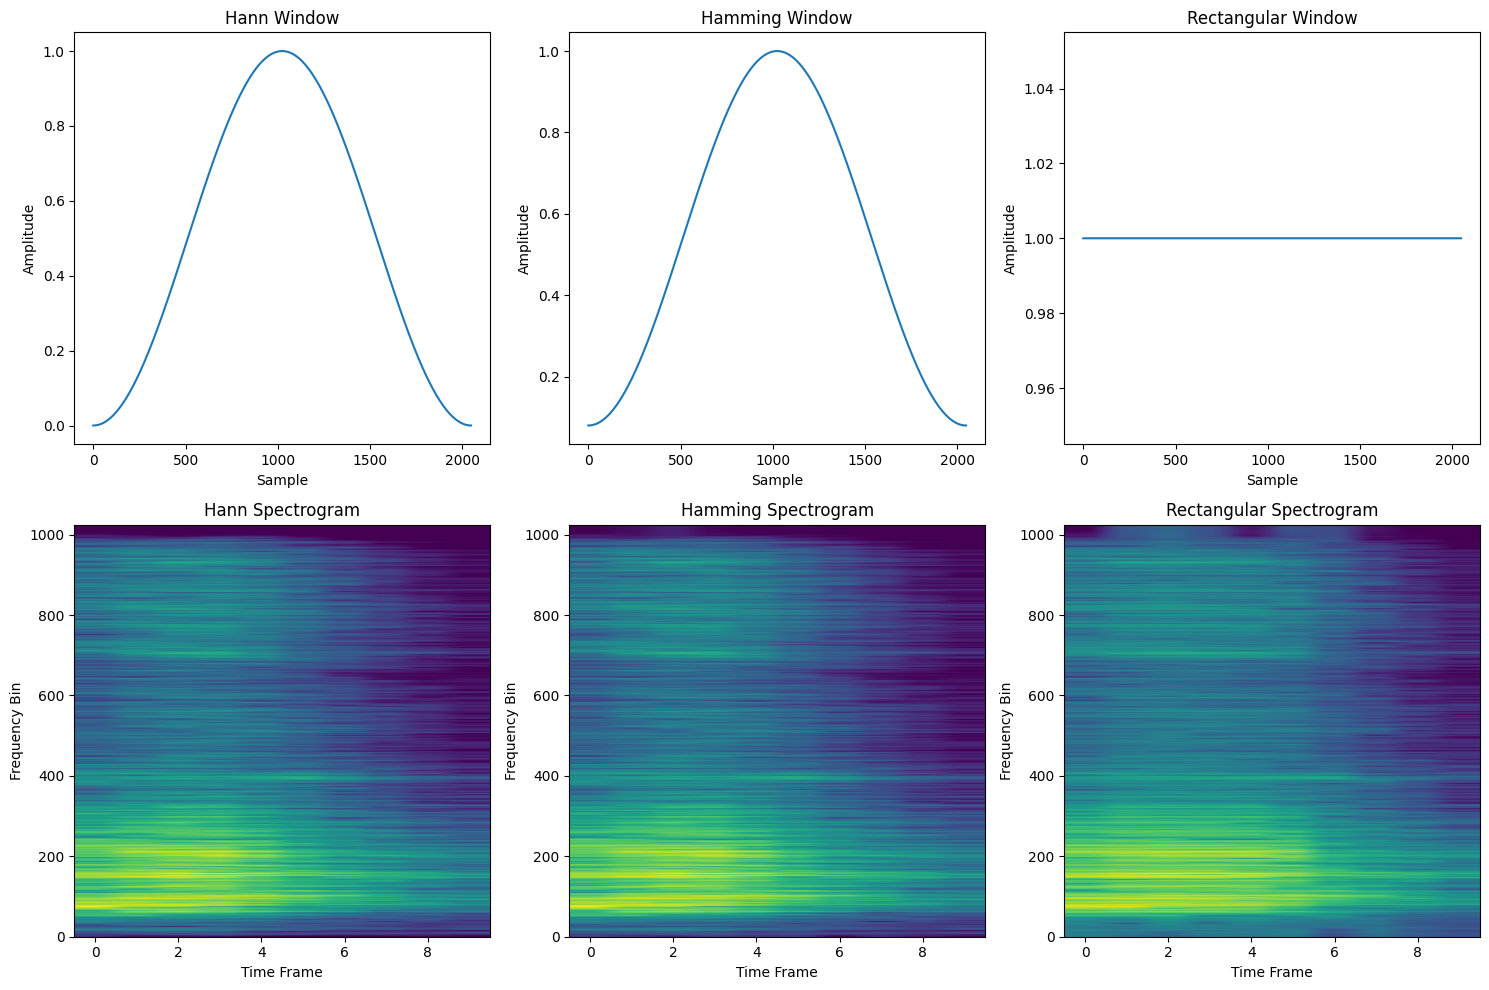

In [12]:
# Load first sample from dataset to compare windows
signal, _ = librosa.load(datasets['hann'].file_paths[0], sr=22050, duration=2.5)
fig = compare_windows(signal)
plt.show()

In [13]:
class ResNetAudioClassifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNetAudioClassifier, self).__init__()
       
        self.resnet = models.resnet50(pretrained=pretrained)
        
      
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
       
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)
        

Using device: cuda
Initializing hann window dataset...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Initializing hamming window dataset...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing rectangular window dataset...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training model with hann window

Training with hann window:


Epoch 1/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 1/5:
Train Loss: 1.5039, Train Acc: 46.46%
Val Loss: 1.1602, Val Acc: 60.62%


Epoch 2/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 2/5:
Train Loss: 0.9764, Train Acc: 67.14%
Val Loss: 1.3240, Val Acc: 62.56%


Epoch 3/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 3/5:
Train Loss: 0.6726, Train Acc: 77.62%
Val Loss: 0.8414, Val Acc: 75.39%


Epoch 4/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 4/5:
Train Loss: 0.4438, Train Acc: 86.03%
Val Loss: 0.3540, Val Acc: 88.67%


Epoch 5/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 5/5:
Train Loss: 0.2728, Train Acc: 91.44%
Val Loss: 0.2955, Val Acc: 90.73%

Final metrics for hann window:
Accuracy: 0.9073
Precision: 0.9078
Recall: 0.9073
F1 Score: 0.9072


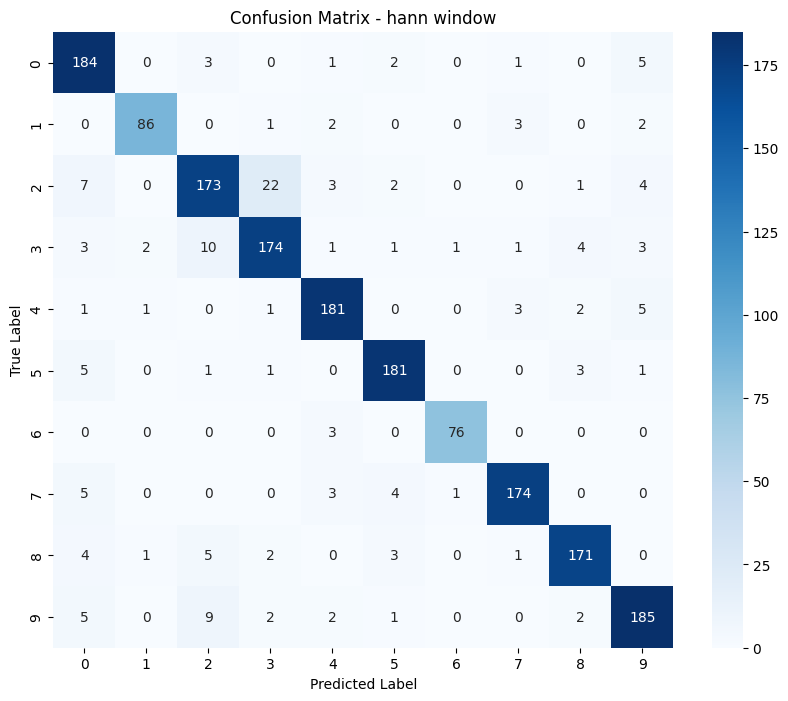


Training model with hamming window

Training with hamming window:


Epoch 1/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 1/5:
Train Loss: 1.5493, Train Acc: 44.60%
Val Loss: 1.3110, Val Acc: 55.41%


Epoch 2/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 2/5:
Train Loss: 1.0101, Train Acc: 66.04%
Val Loss: 1.3020, Val Acc: 55.92%


Epoch 3/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 3/5:
Train Loss: 0.6855, Train Acc: 77.58%
Val Loss: 0.6921, Val Acc: 77.79%


Epoch 4/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 4/5:
Train Loss: 0.4727, Train Acc: 84.90%
Val Loss: 0.3996, Val Acc: 87.24%


Epoch 5/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 5/5:
Train Loss: 0.2893, Train Acc: 91.11%
Val Loss: 0.3329, Val Acc: 89.30%

Final metrics for hamming window:
Accuracy: 0.8930
Precision: 0.8948
Recall: 0.8930
F1 Score: 0.8929


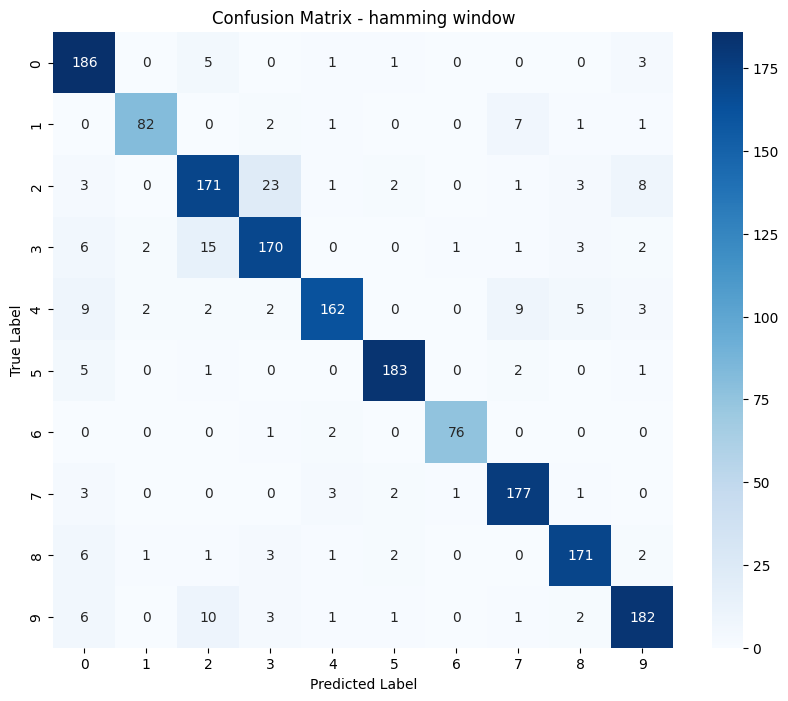


Training model with rectangular window

Training with rectangular window:


Epoch 1/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 1/5:
Train Loss: 1.5079, Train Acc: 45.58%
Val Loss: 1.9270, Val Acc: 38.24%


Epoch 2/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 2/5:
Train Loss: 0.9772, Train Acc: 66.56%
Val Loss: 0.8409, Val Acc: 72.47%


Epoch 3/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 3/5:
Train Loss: 0.6757, Train Acc: 78.07%
Val Loss: 1.0602, Val Acc: 67.32%


Epoch 4/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 4/5:
Train Loss: 0.4718, Train Acc: 84.41%
Val Loss: 0.4417, Val Acc: 85.80%


Epoch 5/5 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 5/5:
Train Loss: 0.2868, Train Acc: 90.87%
Val Loss: 0.3460, Val Acc: 89.58%

Final metrics for rectangular window:
Accuracy: 0.8958
Precision: 0.8976
Recall: 0.8958
F1 Score: 0.8960


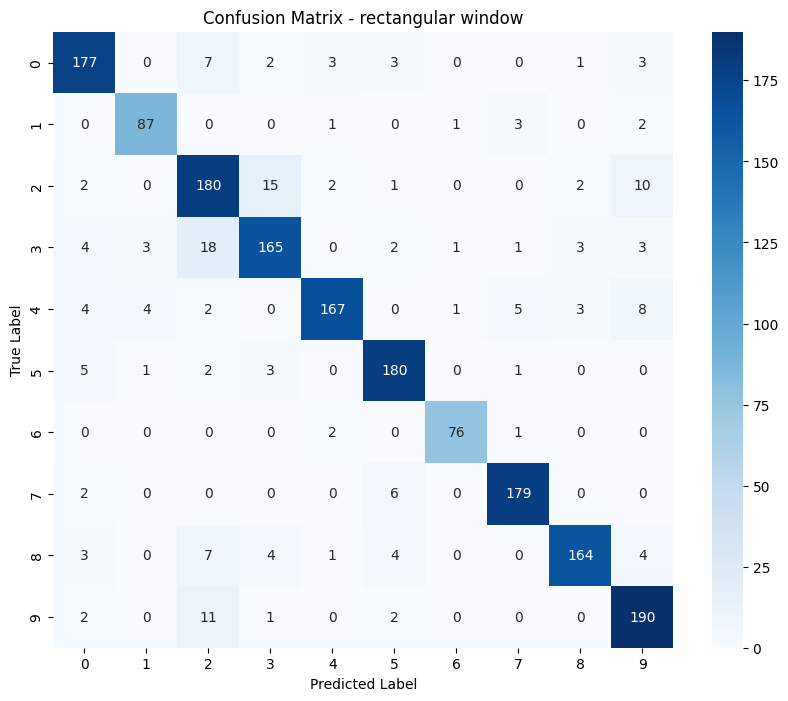

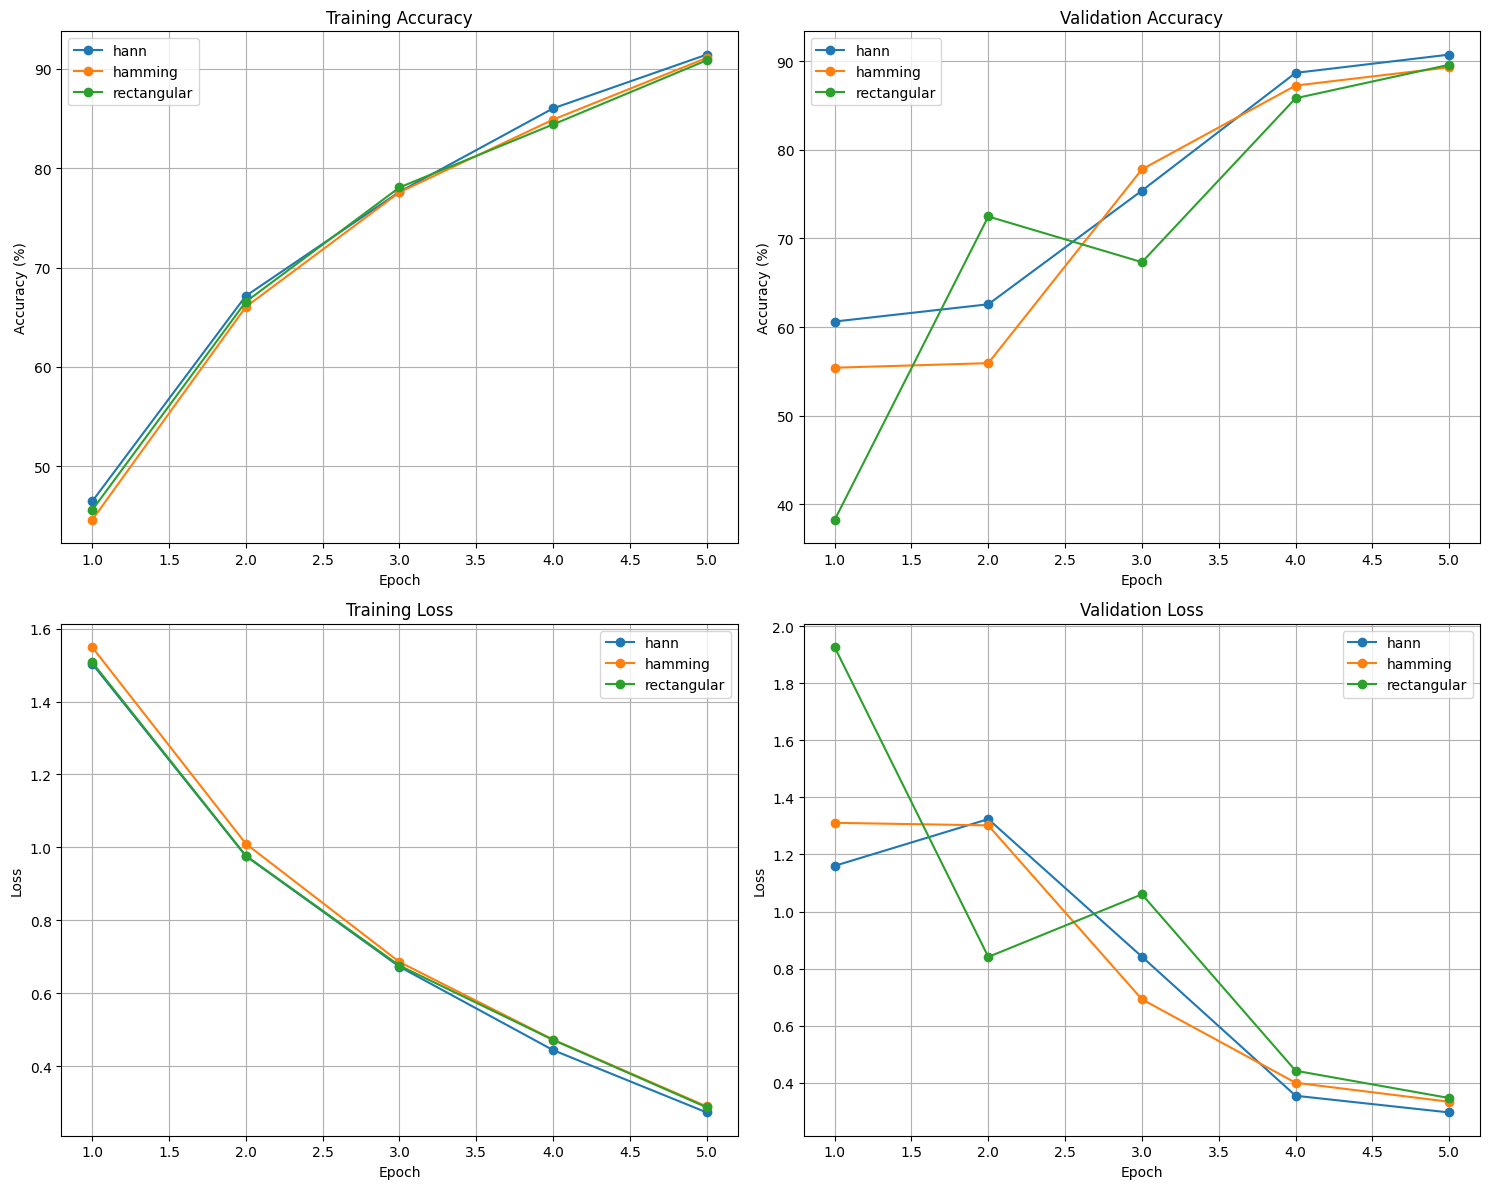

In [14]:
class WindowingExperiment:
    def __init__(self, dataset_path, metadata_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"Using device: {self.device}")
        self.window_types = ['hann', 'hamming', 'rectangular']
        self.datasets = {}
        self.models = {}
        self.results = {}
        
       
        for wtype in self.window_types:
            print(f"Initializing {wtype} window dataset...")
            self.datasets[wtype] = UrbanSoundDataset(metadata_path, dataset_path, window_type=wtype)
            self.models[wtype] = ResNetAudioClassifier().to(device)
    
    def prepare_data(self, window_type, batch_size=32, train_split=0.8):
        dataset = self.datasets[window_type]
        
        train_size = int(train_split * len(dataset))
        val_size = len(dataset) - train_size
        
        train_dataset, val_dataset = random_split(
            dataset, 
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        return train_loader, val_loader
    
    def train_model(self, window_type, num_epochs=10):
        model = self.models[window_type]
        train_loader, val_loader = self.prepare_data(window_type)
        
        # Use cross entropy loss
        criterion = nn.CrossEntropyLoss()
        
        # Use AdamW optimizer with weight decay
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        
        # Learning rate scheduler with warmup
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            epochs=num_epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1  # 10% warmup
        )
        
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'predictions': [], 'true_labels': []
        }
        
        best_val_acc = 0
        
        print(f"\nTraining with {window_type} window:")
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
            for spectrograms, labels in train_pbar:
                spectrograms = spectrograms.unsqueeze(1).float().to(self.device)
                labels = labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(spectrograms)
                loss = criterion(outputs, labels)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
                
                train_pbar.set_postfix({'loss': f'{train_loss/train_total:.4f}', 
                                      'acc': f'{100.*train_correct/train_total:.2f}%'})
            
            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            all_predictions = []
            all_labels = []
            
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            with torch.no_grad():
                for spectrograms, labels in val_pbar:
                    spectrograms = spectrograms.unsqueeze(1).float().to(self.device)
                    labels = labels.to(self.device)
                    
                    outputs = model(spectrograms)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
                    
                    all_predictions.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    val_pbar.set_postfix({'loss': f'{val_loss/val_total:.4f}', 
                                        'acc': f'{100.*val_correct/val_total:.2f}%'})
            
            # Calculate metrics
            train_loss = train_loss / len(train_loader)
            train_acc = 100. * train_correct / train_total
            val_loss = val_loss / len(val_loader)
            val_acc = 100. * val_correct / val_total
            
            # Save best predictions
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                history['predictions'] = all_predictions
                history['true_labels'] = all_labels
            
            # Save history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f'\nEpoch {epoch+1}/{num_epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        self.results[window_type] = history
        return history
    
    def evaluate_all(self, num_epochs=1):
        all_metrics = {}
        
        for window_type in self.window_types:
            print(f"\n{'='*50}")
            print(f"Training model with {window_type} window")
            print(f"{'='*50}")
            
            history = self.train_model(window_type, num_epochs)
            
            # Calculate final metrics
            y_true = history['true_labels']
            y_pred = history['predictions']
            
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
            
            metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            }
            
            all_metrics[window_type] = metrics
            
            print(f"\nFinal metrics for {window_type} window:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            
            # Plot confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {window_type} window')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
        
        return all_metrics
    
    def plot_results(self):
        """
        Plot training and validation metrics for all window types.
        """
        if not self.results:
            print("No results to plot. Please run evaluate_all() first.")
            return
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        for window_type in self.window_types:
            history = self.results[window_type]
            epochs = range(1, len(history['train_acc']) + 1)
            
            # Plot training accuracy
            ax1.plot(epochs, history['train_acc'], label=f'{window_type}', marker='o')
            ax1.set_title('Training Accuracy')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Accuracy (%)')
            ax1.legend()
            ax1.grid(True)
            
            # Plot validation accuracy
            ax2.plot(epochs, history['val_acc'], label=f'{window_type}', marker='o')
            ax2.set_title('Validation Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy (%)')
            ax2.legend()
            ax2.grid(True)
            
            # Plot training loss
            ax3.plot(epochs, history['train_loss'], label=f'{window_type}', marker='o')
            ax3.set_title('Training Loss')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Loss')
            ax3.legend()
            ax3.grid(True)
            
            # Plot validation loss
            ax4.plot(epochs, history['val_loss'], label=f'{window_type}', marker='o')
            ax4.set_title('Validation Loss')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Loss')
            ax4.legend()
            ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

# Example usage
DATASET_PATH = "/kaggle/input/speech-dataset/UrbanSound8K/audio"
METADATA_PATH = "/kaggle/input/speech-dataset/UrbanSound8K/metadata/UrbanSound8K.csv"

# Create and run experiment
experiment = WindowingExperiment(DATASET_PATH, METADATA_PATH)
metrics = experiment.evaluate_all(num_epochs=5)
experiment.plot_results()

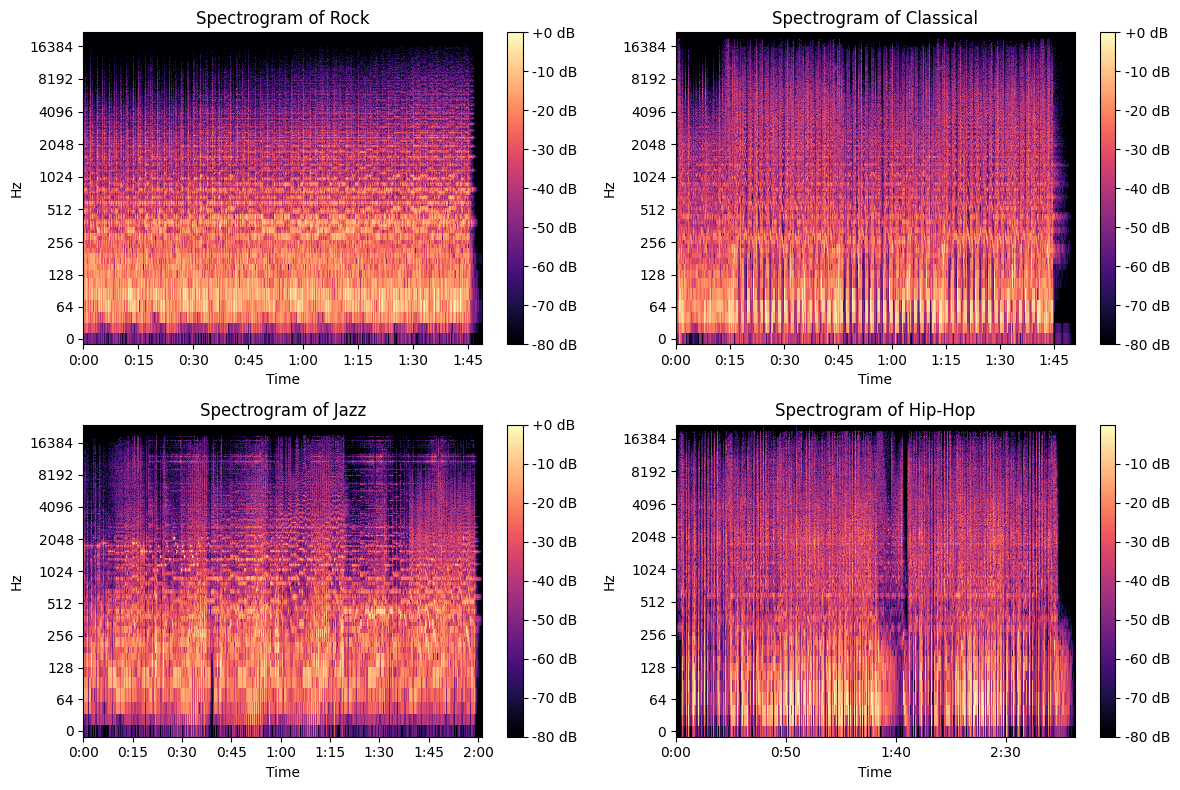

In [16]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load four songs from different genres
files = {
    "Rock": "/kaggle/input/songs/songs/Rock_1.wav",
    "Classical": "/kaggle/input/songs/songs/classsical.wav",
    "Jazz": "/kaggle/input/songs/songs/Jazz_1.wav",
    "Hip-Hop": "/kaggle/input/songs/songs/Hip_Hop.wav"
}

plt.figure(figsize=(12, 8))

for i, (genre, file) in enumerate(files.items()):
    # Load the audio file
    y, sr = librosa.load(file, sr=None)

    # Compute Short-Time Fourier Transform (STFT)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Plot spectrogram
    plt.subplot(2, 2, i+1)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram of {genre}")

plt.tight_layout()
plt.show()
